# Baum - Welch Reparameterization

A popular classic method in the HMM literature for inferring model parameters is the *Expectation-Maximization* algorithm. The primary tools needed for this mode of estimation is simply the forward and backward probabilities ($P(x_t|Y^{[0, t]})$ and $P(x_t|Y^{[t, T]})$, respectively) that we have already built up the necessary logic to estimate. In the context of HMMs, the expectation-maximization algorithm is referred to as the *Baum-Welch* optimization algorithm.

In general an expectation-maximization algorithm is an iterative method for performing maximum likelihood estimation when some of the data are missing. This method exploits the fact that the *Complete-Data Log-Likelihood* (CDLL) may be straightforward to maximize, even if the likelihood of the observed data is not.  Here, the CDLL is simply the true log-likelihood function of parameters $\theta$ based on both the observed and missing data.

Informally, the algorithm can be described as follows: start witih an initial guess for the paramerer vector $\theta_i$ and then iterate the following two steps until the desired convergence is reached:

- ***Expectation***: Compute conditional expectation values of the missing data given the observed data and the current estimate of parameters ($\theta$). Or, precisely, compute the conditional expectations of those functions of missing data that appear in the CDLL
- ***Maximization***: Maximize (with respect to $\theta$) the CDLL with the functions of the missing data replaced with their conditional expectations.

By iterating this process, the parameter vector will converge towards a local maximum of the likelihood function

known as the *Baum-Welch* algorithm, and is a particular instance of an Expectation-Maximization algorithm. While this algorithm still seeks to find the maximum likelihood solution to the problems introduced earlier, the procedure is slightly different, and can better solve for a unique minimum, while scaling better at times with dimensions.

Specifically, the BW algorithm (like all EM algorithms) takes place over two steps, which are iterated over until a convergence criteria has been reached. Those steps are:
- **Expectation**: calculate the most probable set of hidden states given a set of parameters
- **Maximization**: Assuming the hidden state sequence in the previous step is correct, what is the maximum likelihood set of transition parameters

Unlike the previous naive likelihood maximization, this algorithm works by first calculating the maximum likelihood (Bayesian) estimate of the hidden state given the observed sequence of states (assuming fixed transition $A$ and observation $B$ matrices):

$$ \gamma_i^t \equiv P(x_t = i| Y^T)$$

where $\gamma_i^t$ represents the probability of the hidden state being in state $i$ at time $t$, given the entire history of observations $Y^T$ (from $t=0 \to N$).

This represents the *expectation* step. Next, we update the parameters of the $A$ and $B$ matrix in the following way:

First, we calculate the transition probability of hidden state transitions, given all observations:

$$ \xi_t^{ji} \equiv P(x_t = i, x_{t+1} = j | Y^T ) = P(x_t = i | Y^{[0, t]})P(x_t = i, x_{t+1} = j)P(x_{t+1} = j | Y^{[t+1, T]} )P(y_{t+1} = j | x_{t=1} = j) $$

From this equation, we already know a few terms: $P(x_t = i| Y^{[0, t]})$ is simply the forward probability at tiem step $t$, similarly $P(x_{t+1} = j | Y^{[t+1, T]})$ is the backward probability at time $t+1$, the last term $P(y_{t+1} = j| X_{t+1} = j)$ is just the matrix element $B_{jj}$ of the observation matrix. Therefore, to determine $\xi_t^{ij}$, we just need to determine the middle term $P(x_t = i, x_{t+1} = j)$. However, this middle term is just the matrix element $A_{ij}$: the probability of a transition from $x_i \to x_j$. Therefore, we have the entire expression built from terms already at our disposal.

Once we have this $\xi_t^{ji}$ term, we update the transition matrix elements as

$$ A_{ij}^* = \frac{\sum_{t=1}^T \xi_t^{ij} }{\sum_{t=1}^T \gamma_i^t } $$

which is simply the expecten number of transitions $i\to j$ divided by the number of times that the system was in state $i$.
This provides the logic for updating the transition matrix terms, the remaining piece is to update the observation matrix terms.  Here, we set

$$ B_{ij}^* =  \frac{\sum_{t=1}^T \mathcal{I}[y_t = i]\gamma_j^t}{\sum_{t=1}^T \gamma_j^t}$$

Which can alternatively be written as

$$ B_{ij}^* = \frac{\sum_{t | y_t = i} \gamma_i^t}{\sum_{t=1}^T \gamma_i^t} $$ 

Which, intuitively, serves as a measure of the relative probability of being in state $i$ when the obervation is $i$.

For each of these expressions there are $N\times N$ terms to evaluate.



In [1]:
# First, import the necessary modules
import os
import numpy as np
from typing import Iterable, Optional, Tuple, Callable
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="hls")

from hidden import dynamics
from hidden import infer

# here we assume the dynamics are symmetric
a = 0.1
b = 0.2

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

In [2]:
hmm.initialize_dynamics(A, B)
hmm.run_dynamics(1000)
obs_ts = hmm.get_obs_ts()
state_ts = hmm.get_state_ts()

In [3]:
bayes_infer = infer.MarkovInfer(2, 2)

# First, we can check the forward and backward algorithms to be sure that there are no off-by-one errors
bayes_infer.forward_algo(obs_ts, A, B)
bayes_infer.backward_algo(obs_ts, A, B)

# Prediction of the forward and backward algorithms at each point in time
fwd_pred = [np.argmax(i) for i in bayes_infer.forward_tracker]
bak_pred = [np.argmax(i) for i in bayes_infer.backward_tracker]

# Probabilities of the system being in state 1
fwd_prob_one = [i[1] for i in bayes_infer.forward_tracker]
bak_prob_one = [i[1] for i in bayes_infer.backward_tracker]

# Smoothing operation
bayes_infer.bayesian_smooth(A)
smooth_prob_one = [i[1] for i in bayes_infer.bayes_smoother]


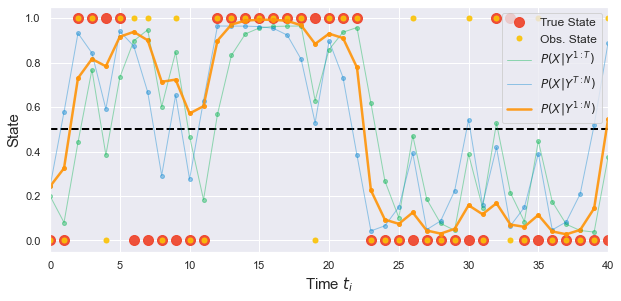

In [4]:

fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))

ax.axhline(0.5, linestyle='--', linewidth=2.0, color='k')

ax.plot(state_ts, 'o', markersize=10, color=sns.xkcd_rgb["tomato"], alpha=0.9, label="True State")
ax.plot(obs_ts, 'o', markersize=5, color=sns.xkcd_rgb["goldenrod"], alpha=0.9, label="Obs. State")

ax.plot(fwd_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["shamrock"], alpha=0.4)
ax.plot(bak_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["cerulean"], alpha=0.4)
ax.plot(smooth_prob_one, 'o', markersize=4, color=sns.xkcd_rgb["tangerine"], alpha=0.9)

ax.plot(fwd_prob_one, linewidth=1.0, color=sns.xkcd_rgb["shamrock"], alpha=0.4, label=r"$P(X|Y^{1:T})$")
ax.plot(bak_prob_one, linewidth=1.0, color=sns.xkcd_rgb["cerulean"], alpha=0.4, label=r"$P(X|Y^{T:N})$")
ax.plot(smooth_prob_one, linewidth=2.5, color=sns.xkcd_rgb["tangerine"], alpha=0.9, label=r"$P(X|Y^{1:N})$")

ax.set_xlim([0,40])
ax.set_xlabel(r"Time $t_i$", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
ax.legend(fontsize=12, ncol=1, frameon=True)


In [5]:
# Here, we can see that the smoother estimate gets most inferrences right (at
# least for this window slice), while both the forward, and backward algorithms
# get some wrong. The smoother gets fooled by the quick state switch around t=15
# but not on either end of the more prolonged state switch around t=20 - 26

pred_smooth = [np.argmax(i) for i in bayes_infer.bayes_smoother]


def error_rate(pred: Iterable, real: Iterable) -> float:
    return 1 - np.mean([p == s for p, s in zip(pred, real)])


print(f"Error (Fwd)    : {error_rate(fwd_pred, state_ts)}")
print(f"Error (Back)   : {error_rate(bak_pred, state_ts)}")
print(f"Error (Smooth) : {error_rate(pred_smooth, state_ts)}")

Error (Fwd)    : 0.15900000000000003
Error (Back)   : 0.15200000000000002
Error (Smooth) : 0.10799999999999998


In [6]:
# Now, to actually run the Baum Welch procedure, we can start with an estimate
# of the HMM matrices
# The true matrices are 
# A = [[0.9, 0.1], [0.1, 0.9]]
# B = [[0.8, 0.2], [0.8, 0.2]]
# So, lets start with aymmetric, and not-too-wrong estimates

a_est = 0.21
b_est = 0.13

A_est = np.array([[1 - a_est, a_est],[a_est, 1 - a_est]])
B_est = np.array([[1 - b_est, b_est],[b_est, 1 - b_est]])

param_init = (A_est[0, 0], B_est[0, 0])

bayes_infer = infer.MarkovInfer(2, 2)
bw_res = bayes_infer.baum_welch(param_init, obs_ts)



In [14]:
# Sad...
bw_res.A_opt


array([[1.00000000e+00, 5.84284656e-01],
       [5.59092625e-40, 1.66510910e-39]])